In [1]:
import sys
import os

# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


# Implied Volatility and Volatility Surface Demo

This notebook demonstrates:
1. Computing implied volatility from option market prices.
2. Building a volatility smile (across strikes).
3. Constructing a volatility surface (across strikes and maturities).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from options_pricing.black_scholes import black_scholes_price
from options_pricing.volatility import implied_volatility, implied_vol_surface


## 1. Implied Volatility of a Single Option
We start by computing the price of a European call using Black-Scholes, 
then recover its volatility using the implied volatility solver.


In [3]:
S, K, T, r, sigma_true = 100, 100, 1.0, 0.05, 0.25

price = black_scholes_price(S, K, T, r, sigma_true, option_type="call")
sigma_est = implied_volatility(price, S, K, T, r, option_type="call")

print(f"True σ = {sigma_true:.4f}")
print(f"Implied σ = {sigma_est:.4f}")


True σ = 0.2500
Implied σ = 0.2500


## 2. Volatility Smile
We fix maturity `T = 1.0` and vary strikes.  
True vol is constant, but the implied vol curve can change if market prices deviate.


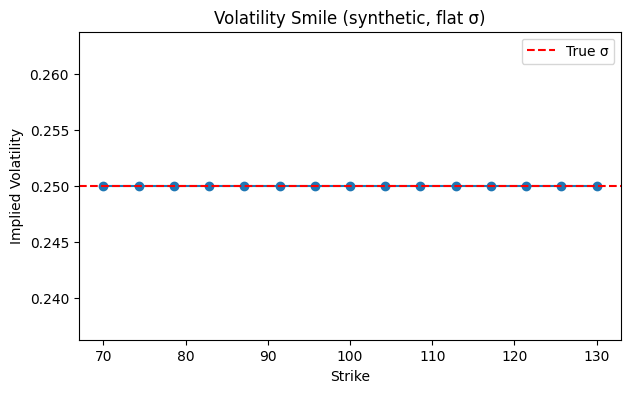

In [4]:
strikes = np.linspace(70, 130, 15)
prices = [black_scholes_price(S, K, T, r, sigma_true, "call") for K in strikes]
ivols = np.array([implied_volatility(p, S, K, T, r, "call") for p, K in zip(prices, strikes)])
ivols = np.round(ivols, 4)
ivols = np.where((ivols > 0) & (ivols < 5), ivols, np.nan)

valid = ~np.isnan(ivols)




plt.figure(figsize=(7,4))
plt.plot(strikes, ivols, marker="o")
plt.axhline(sigma_true, color="red", linestyle="--", label="True σ")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Volatility Smile (synthetic, flat σ)")
plt.legend()
plt.show()


## 3. Volatility Surface
We now build a small surface across maturities and strikes.

In [5]:
maturities = np.array([0.25, 0.5, 1.0, 2.0])
strikes = np.linspace(80, 120, 9)

# Generate synthetic prices with constant vol
prices = np.zeros((len(maturities), len(strikes)))
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        prices[i, j] = black_scholes_price(S, K, T, r, sigma_true, "call")

surface = implied_vol_surface(prices, S, strikes, maturities, r, "call")


### Plot the Volatility Surface


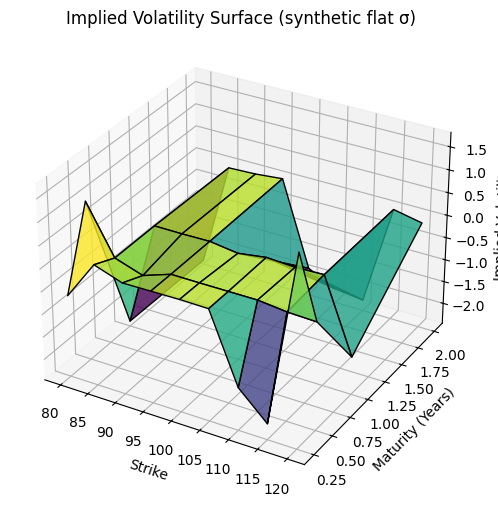

In [6]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(strikes, maturities)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, surface, cmap="viridis", edgecolor="k", alpha=0.8)

ax.set_xlabel("Strike")
ax.set_ylabel("Maturity (Years)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface (synthetic flat σ)")
plt.show()
